In [1]:
#Import all the necessary libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import copy
import warnings
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib.colors import TwoSlopeNorm
from torch.utils.data import TensorDataset, DataLoader

# Functions

In [2]:
#This function evaluates the specific angular coefficients at given energy value

def Y(energy, f_mode):
    Y = torch.zeros((4, 1))

    #Convert Energy to PeV
    xe = .5 + 20 * (torch.log(energy) - log_01) / (log_10 - log_01)
    xe2 = xe * xe

    #Evaluate Y for given energy and mode
    for i in range(4):
        if f_mode == "mg0":
            Y[i] = torch.exp(PXmg_p[i, 0, 0]) + torch.exp(PXmg_p[i ,0, 1] * torch.pow(xe, PXmg_p[i, 0, 2]))

        elif f_mode == "mg2":
            Y[i] = PXmg_p[i, 2, 0] + PXmg_p[i, 2, 1] * xe + PXmg_p[i, 2, 2] * xe2

        elif f_mode == "eg0":
            Y[i] = PXeg_p[i, 0, 0] * torch.exp(PXeg_p[i, 0, 1] * torch.pow(xe, PXeg_p[i, 0, 2]))

        elif f_mode == "eg1":
            Y[i] = PXeg_p[i, 1, 0] + PXeg_p[i, 1, 1] * xe + PXeg_p[i, 1, 2] * xe2

        elif f_mode == "eg2":
            Y[i] = PXeg_p[i, 2, 0] + PXeg_p[i, 2, 1] * xe + PXeg_p[i, 2, 2] * xe2

        elif f_mode == "mp0":
            Y[i] = torch.exp(PXmp_p[i, 0, 0]) + torch.exp(PXmp_p[i, 0, 1] * torch.pow(xe, PXmp_p[i, 0, 2]))

        elif f_mode == "mp2":
            Y[i] = PXmp_p[i, 2, 0] + PXmp_p[i, 2, 1] * xe + PXmp_p[i, 2, 2] * xe2

        elif f_mode == "ep0":
            Y[i] = torch.exp(PXep_p[i, 0, 0]) + torch.exp(PXep_p[i, 0, 1] * torch.pow(xe, PXep_p[i, 0, 2]))

        elif f_mode == "ep1":
            Y[i] = PXep_p[i, 1, 0] + PXep_p[i, 1, 1] * xe + PXep_p[i, 1, 2] * xe2

        elif f_mode == "ep2":
            Y[i] = PXep_p[i, 2, 0] + PXep_p[i, 2, 1] * xe + PXep_p[i, 2, 2] * xe2

        else:
            warnings.warn("The Mode is not defined")
            return

    return Y

In [3]:
#Interpolated parameter computation
#thisp0 = normalization constant
#thisp1 = slope parameter
#thisp2 = shape parameter

def thisp(energy, theta, f_mode):
    #Find Y values
    Y_val = Y(energy, f_mode)

    #Solve for B
    B = torch.linalg.solve(A, Y_val)

    #Define x from theta
    x = .5 + 4 * theta / theta_max

    res = 0

    for i in range(4):
        res += B[i] * x ** i

    return res

In [4]:
def ReadShowers(path_g, path_p):
    #GAMMA SHOWERS
    #Reading the Electron Parameters in the Showers
    PXeg1_p = np.loadtxt(path_g, max_rows = 3)

    for i in range(3):
        if PXeg1_p[i, 0]*PXeg1_p[i, 1]*PXeg1_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXeg2_p = np.loadtxt(path_g, skiprows = 3, max_rows = 3)
    
    for i in range(3):
        if PXeg2_p[i, 0]*PXeg2_p[i, 1]*PXeg2_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXeg3_p = np.loadtxt(path_g, skiprows = 6, max_rows = 3)
    
    for i in range(3):
        if PXeg3_p[i, 0]*PXeg3_p[i, 1]*PXeg3_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXeg4_p = np.loadtxt(path_g, skiprows = 9, max_rows = 3)
    
    for i in range(3):
        if PXeg4_p[i, 0]*PXeg4_p[i, 1]*PXeg4_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return
            
    #Reading the Muon Parameters in the Showers
    PXmg1_p = np.loadtxt(path_g, skiprows = 12, max_rows = 3)
    
    for i in range(3):
        if PXmg1_p[i, 0]*PXmg1_p[i, 1]*PXmg1_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return
            
    PXmg2_p = np.loadtxt(path_g, skiprows = 15, max_rows = 3)
    
    for i in range(3):
        if PXmg2_p[i, 0]*PXmg2_p[i, 1]*PXmg2_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmg3_p = np.loadtxt(path_g, skiprows = 18, max_rows = 3)
    
    for i in range(3):
        if PXmg3_p[i, 0]*PXmg3_p[i, 1]*PXmg3_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmg4_p = np.loadtxt(path_g, skiprows = 21, max_rows = 3)
    
    for i in range(3):
        if PXmg4_p[i, 0]*PXmg4_p[i, 1]*PXmg4_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    #PROTON SHOWERS
    #Reading the Electron Parameters in the Showers
    PXep1_p = np.loadtxt(path_p, max_rows = 3)

    for i in range(3):
        if PXep1_p[i, 0]*PXep1_p[i, 1]*PXep1_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXep2_p = np.loadtxt(path_p, skiprows = 3, max_rows = 3)
    
    for i in range(3):
        if PXep2_p[i, 0]*PXep2_p[i, 1]*PXep2_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXep3_p = np.loadtxt(path_p, skiprows = 6, max_rows = 3)
    
    for i in range(3):
        if PXep3_p[i, 0]*PXep3_p[i, 1]*PXep3_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXep4_p = np.loadtxt(path_p, skiprows = 9, max_rows = 3)
    
    for i in range(3):
        if PXep4_p[i, 0]*PXep4_p[i, 1]*PXep4_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return
            
    #Reading the Muon Parameters in the Showers
    PXmp1_p = np.loadtxt(path_p, skiprows = 12, max_rows = 3)
    
    for i in range(3):
        if PXmp1_p[i, 0]*PXmp1_p[i, 1]*PXmp1_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmp2_p = np.loadtxt(path_p, skiprows = 15, max_rows = 3)
    
    for i in range(3):
        if PXmp2_p[i, 0]*PXmp2_p[i, 1]*PXmp2_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmp3_p = np.loadtxt(path_p, skiprows = 18, max_rows = 3)
    
    for i in range(3):
        if PXmp3_p[i, 0]*PXmp3_p[i, 1]*PXmp3_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmp4_p = np.loadtxt(path_p, skiprows = 21, max_rows = 3)
    
    for i in range(3):
        if PXmp4_p[i, 0]*PXmp4_p[i, 1]*PXmp4_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmg_p = torch.tensor([PXmg1_p, PXmg2_p, PXmg3_p, PXmg4_p])
    PXeg_p = torch.tensor([PXeg1_p, PXeg2_p, PXeg3_p, PXeg4_p])
    PXmp_p = torch.tensor([PXmp1_p, PXmp2_p, PXmp3_p, PXmp4_p])
    PXep_p = torch.tensor([PXep1_p, PXep2_p, PXep3_p, PXep4_p])

    return PXmg_p, PXeg_p, PXmp_p, PXep_p

In [5]:
#This function parametrize the particle species content from the showers
#We find the flux of the particles for a given energy, angle and distance
#f_mode is used to tell the code which particle species we are dealing with, beacuse equation changes
#whether we are dealing with muons or electrons

def ShowerContent(energy, theta, R, f_mode):
    #Check if everything is in the range:
    if R < R_min:
        R = torch.tensor([R_min], requires_grad = True)

    if energy < .1 or energy > 10:
        warnings.warn("Energy is out of range!")
        return 0

    if theta < 0 or theta > theta_max:
        warnings.warn("Angle is out of range!")
        return 0
    
    if f_mode == "mg" or f_mode == "mp":
        thisp0 = thisp(energy, theta, f_mode + "0")
        thisp2 = thisp(energy, theta, f_mode + "2")
        
        #Evaluate the  Flux
        flux0 = TankArea * .02 * thisp0 * torch.exp(-1 * torch.pow(R, thisp2))

    elif f_mode == "eg" or f_mode == "ep":
        thisp0 = thisp(energy, theta, f_mode + "0")
        thisp1 = thisp(energy, theta, f_mode + "1")
        thisp2 = thisp(energy, theta, f_mode + "2")
        
        #Evaluate the Flux
        flux0 = TankArea * thisp0 * torch.exp(-thisp1 * torch.pow(R, thisp2))

    else:
        warnings.warn("Mode is not defined")
        return

    #We need to make sure that flux is non negative or too large
    if flux0.item() < epsilon:
        flux0 = torch.tensor([epsilon], dtype = torch.float32)

    if flux0.item() > largenumber:
        flux0 = torch.tensor([largenumber], dtype = torch.float32)

    return flux0

In [6]:
#This function defines the initial layouts of the detectors, N_det = 4000
#At this point of the project, we just define a square grid

def Layouts():
    x = np.linspace(-1000, 1000, 20)
    y = np.linspace(-1000, 1000, 20)

    detector_pos = [(i, j) for i in x for j in y]
    x = np.array(detector_pos)[:, 0]
    y = np.array(detector_pos)[:, 1]
    return x, y

In [7]:
#We will generate the showers here, getting the energy, angle, and position of the shower core

def GenerateShowers():
    #Define the position of the shower cores
    X0 = torch.tensor([np.random.uniform(-1000, 1000)], dtype = torch.float32, requires_grad = True)
    Y0 = torch.tensor([np.random.uniform(-1000, 1000)], dtype = torch.float32, requires_grad = True)

    #Define the energy and angles
    energy = torch.tensor([np.random.uniform(.1, 10)], dtype = torch.float32, requires_grad = True)
    theta = torch.tensor([np.random.uniform(0, theta_max)], dtype = torch.float32, requires_grad = True)
    phi = torch.tensor([np.random.uniform(-np.pi, np.pi)], dtype = torch.float32)

    #Debugging part
    if debug == True:
        #Shower Core is at origin
        X0 = torch.tensor([.0], dtype = torch.float32, requires_grad = True)
        Y0 = torch.tensor([.0], dtype = torch.float32, requires_grad = True)
        #Energy is 1 PeV
        energy = torch.tensor([1.], dtype = torch.float32, requires_grad = True)
        #30 degree angle of incidence
        theta = torch.tensor([np.pi / 6], dtype = torch.float32, requires_grad = True)
        
        phi = torch.tensor([.0], dtype = torch.float32, requires_grad = True)

    #Evalute the counts in the tanks
    N, T = GetCounts(energy, theta, phi, X0, Y0)

    return N, T, X0, Y0, energy, theta, phi

In [8]:
#This function gets the counts and the times in detector units
#For each detector we have, first, we evaluate its distance from the shower core
#Then we evaluate the flux by using previously defined ShowerContent function
#Since we detect number of particles, we put the value in poisson distribution
#Then we smear the value, since we have some uncertainty on detecting particles
#For each unit, we store the number of particles detected in our arrays Ne and Nm
#Then we proceed to evalute the arrival time in each detector

def GetCounts(TrueE, TrueTh, TruePhi, TrueX0, TrueY0):
    Ncount = 0
    Nunits_d = 0 #Counts the number of units with positive number of detected particles
    SumProbGe1 = 0
    Active = False
    PActive = 0

    #Initialize Counts and Times
    Nm = np.zeros(Nunits)
    Ne = np.zeros(Nunits)
    Tm = np.zeros(Nunits)
    Te = np.zeros(Nunits)

    for idx in range(Nunits):
        #At this part we are evaluating the number of particles detected in each unit
        R = EffectiveDistance(x[idx], y[idx], TrueX0, TrueY0, TrueTh, TruePhi)
        ct = torch.cos(TrueTh)

        fbm = 0
        fbe = 0

        #Evaluate the Content
        m0 = ShowerContent(TrueE, TrueTh, R, "mg")
        e0 = ShowerContent(TrueE, TrueTh, R, "eg")
        mb = fluxB_m
        eb = fluxB_e
        
        nms = SmearN(torch.poisson(m0 * ct))
        nes = SmearN(torch.poisson(e0 * ct))

        nmb = SmearN(torch.poisson(fluxB_m))
        neb = SmearN(torch.poisson(fluxB_e))

        Nm[idx] = int((nms + nmb))
        Ne[idx] = int((nes + neb))

        if (m0 + mb) > 0:
            fbm = mb / (m0 + mb)
        if (e0 + eb) > 0:
            fbe = eb / (e0 + eb)

        if (nms + nes + nmb + neb) > 0:
            Nunits_d += 1

        Npexp = (nms + nes + nmb + neb).detach()
        Nobs = Nm[idx] + Ne[idx]

        SumProbGe1 += 1 - np.exp(-Npexp)

        #Handling the timing generation
        et = EffectiveTime(x[idx], y[idx], TrueX0, TrueY0, TrueTh, TruePhi) #expected time of arrival in the unit

        if Ne[idx] > 0:
            TAe_m, TAe_s = TimeAverage(et, neb, nes)
            Te[idx] = torch.normal(TAe_m, TAe_s).item()

        if Nm[idx] > 0:
            TAm_m, TAm_s = TimeAverage(et, nmb, nms)
            Tm[idx] = torch.normal(TAm_m, TAm_s).item()

    return Ne + Nm, Te + Tm

In [9]:
#This function evaluates the distance of the given unit from the shower core
def EffectiveDistance(xd, yd, x0, y0, th, ph):
    dx = xd - x0
    dy = yd - y0
    t = torch.sin(th) * torch.cos(ph) * dx + torch.sin(th) * torch.sin(ph) * dy
    r = dx ** 2 + dy ** 2 - t ** 2

    if r > 0:
        r = torch.sqrt(r)

    if r < R_min:
        r = R_min
    
    return r

In [10]:
#This function evaluates the time of arrival of the particles to the ground
#t = 0 for first arrivals while t > 0 for late arrival particles

def EffectiveTime(xd, yd, x0, y0, th, ph):
    et = ((xd - x0) * torch.sin(th) * torch.cos(ph) + (yd - y0) * torch.sin(th) * torch.sin(ph)) / c0

    return et

In [11]:
#We have some resolution in our detectors, which inherently has some uncertainty in detecting the number of particles
#This function accounts for this uncertainty
#We keep a fix resolution, it does not change for different flux values

def SmearN(flux):
    if flux.item() == 0:
        return torch.tensor([0], dtype = torch.float32)

    else:
        return torch.normal(flux, RelResCounts * flux)

In [12]:
def TimeAverage(T, Nb, Ns):
    Nbgr = torch.poisson(Nb)
    Nsig = torch.poisson(Ns)

    tmin = T - IntegrationWindow * .5
    tmax = T + IntegrationWindow * .5

    if Nb <= 1:
        AvTbgr = torch.empty(1).uniform_(tmin.item(), tmax.item())
        STbgr = IntegrationWindow / sqrt12

    elif Nb <= 2:
        AvTbgr = torch.mean(torch.tensor([np.random.uniform(tmin.item(), tmax.item(), 2)], dtype = torch.float32))
        STbgr = IntegrationWindow * .2041

    elif Nb <= 3:
        AvTbgr = torch.mean(torch.tensor([np.random.uniform(tmin.item(), tmax.item(), 3)], dtype = torch.float32))
        STbgr = IntegrationWindow * .166666

    elif Nb <= 4:
        AvTbgr = torch.mean(torch.tensor([np.random.uniform(tmin.item(), tmax.item(), 4)], dtype = torch.float32))
        STbgr = IntegrationWindow * .1445

    else:
        STbgr = IntegrationWindow * .11
        AvTbgr = torch.normal(T, STbgr)
        
        while (AvTbgr - T > .5 * IntegrationWindow):
            AvTbgr = torch.normal(T, STbgr)

    STsig = sigma_time

    if Ns >= 2:
        STsig = sigma_time / torch.sqrt(Ns - 1)

    AvTsig = torch.normal(T, STsig)

    if Nb == 0 and Ns == 0:
        mean = T
        std = IntegrationWindow / sqrt12

    elif Nb == 0:
        mean = AvTsig
        std = STsig

    elif Ns == 0:
        mean = AvTbgr
        std = STbgr

    else:
        VTbgr = torch.tensor([STbgr ** 2], dtype = torch.float32)
        VTsig = torch.tensor([STsig ** 2], dtype = torch.float32)
        var = torch.sqrt(1 / VTbgr + 1 / VTsig)

        mean = (AvTsig / VTsig + AvTbgr / VTsig) / var
        std = torch.sqrt(var)

    return mean, std

# Neural Network

In this section we are creating our neural network, we will train it with some simulated EAS. the idea is to feed the network with detector positions, with detected number of particles, and time of arrival. Then we neural network output will be energy of the shower, angles, and shower core (X, Y)

We have to determine the number of hidden layers and number of neurons by hand, as there is no optimization regarding these parameters.

We will keep learning rate small, ie. lr = 1e-5, otherwise NN tends to overfit

It might be argued that for the first part there is no reason to keep positions of the detectors as inputs in our network, but that part will be useful when we need to train our NN again for new positions.

In [13]:
class Reconstruction(nn.Module):
    def __init__(self, input_features = 4, num_detectors = 400, hidden_lay1 = 512, hidden_lay2 = 128,
                 hidden_lay3 = 32, output_dim = 5):
        super(Reconstruction, self).__init__()
        self.num_detectors = num_detectors
        self.input_features = input_features

        #We have to flatten the input, since we are using fully connected neural network
        self.L1 = nn.Linear(num_detectors * input_features, hidden_lay1)
        self.L2 = nn.Linear(hidden_lay1, hidden_lay2)
        self.L3 = nn.Linear(hidden_lay2, hidden_lay3)
        self.L4 = nn.Linear(hidden_lay3, output_dim)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1) #This way we drop a fraction of the neurons randomly at iteration,
        #So that our network won't rely on some specific network path

        #Output_dim = 5 means: we will have an output containing (X0, Y0, E0, Theta0, Phi0)

    def forward(self, x):
        out = self.L1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.L2(out)
        out = self.relu(out)
        out = self.L3(out)
        out = self.relu(out)
        out = self.L4(out)
        out = self.tanh(out)

        return out

In [14]:
#These functions are needed to normalize the labels and denormalize the outputs, otherwise the scales change too much that
#NN training will fail
def NormalizeLabels(E, theta, phi):
    E_norm = 2 * (E - .1) / (10 - .1) - 1
    theta_norm = 2 * theta / (theta_max) - 1
    phi_norm = phi / torch.pi
    
    return E_norm, theta_norm, phi_norm

def DenormalizeLabels(E_norm, theta_norm, phi_norm):
    E = 0.1 + (E_norm + 1) * (10 - 0.1) / 2
    theta = (theta_norm + 1) * theta_max / 2
    phi = phi_norm * torch.pi
    
    return E, theta, phi

In [76]:
#We use this class in the case of early stop
#If our network stops improving after some time there is no need to continue

class EarlyStopping:
    def __init__(self, patience = 20, min_delta = 1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Global Variables

In [59]:
#Matrices we use in the functions
PXmg_p, PXeg_p, PXmp_p, PXep_p = ReadShowers("./Fit_Photon_10_pars.txt", "./Fit_Proton_2_pars.txt")
A = torch.tensor([[1, 1, 1, 1],[1, 2, 4, 8], [1, 3, 9, 27], [1, 4, 16, 64]] , dtype = torch.float32)

#Constants
c0 = .29979 #Speed of light in [m / ns] units
theta_max = np.pi * 65 / 180
log_01 = torch.tensor([np.log(.1)], dtype = torch.float32)
log_10 = torch.tensor([np.log(10)], dtype = torch.float32)
sqrt12 = torch.tensor([np.sqrt(12)], dtype = torch.float32)

#Tank Values
IntegrationWindow = 128. #128 ns integration window, SWGO default
sigma_time = 10. #Time resolution assumed for the detectors
R_min = 2.
TankRadius = 1.91
TankArea = TankRadius ** 2 * np.pi
TankNumber = 19

#Background
Bgr_mu_per_m2 = 0.000001826 * IntegrationWindow
fluxB_m = torch.tensor([TankArea * Bgr_mu_per_m2])

Bgr_e_per_m2 = 0.000000200 * IntegrationWindow
fluxB_e = torch.tensor([TankArea * Bgr_e_per_m2])

#Sizes
Nunits = 400
RelResCounts = .05

#Debug Parameters
debug = False
largenumber = 1e13
epsilon = 1 / largenumber

#NN
Nevents = 10000
Nvalidation = 1000

# Main Routine
We will be using here for debugging as well

## Checks

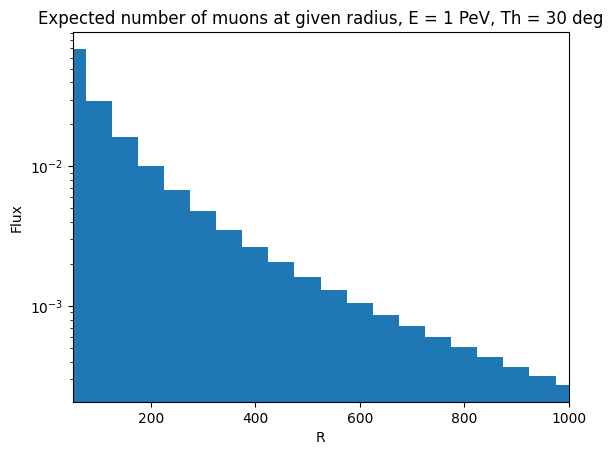

In [16]:
energy = torch.tensor([1.], requires_grad = True)
theta = torch.tensor([np.pi / 6], requires_grad = True)
R = torch.tensor(np.linspace(50, 1000, 20), requires_grad = True)
fluxes = []

for r in R:
    fluxes.append(ShowerContent(energy, theta, r, "mg").item())

plt.bar(R.detach().numpy(), fluxes, width = 50)
plt.yscale('log')
plt.ylabel("Flux")
plt.xlabel("R")
plt.title("Expected number of muons at given radius, E = 1 PeV, Th = 30 deg")
plt.xlim((50, 1000))
plt.show()

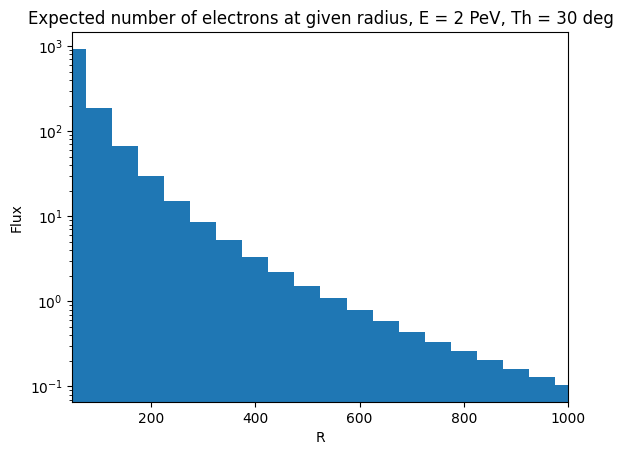

In [17]:
energy = torch.tensor([2.], requires_grad = True)
theta = torch.tensor([np.pi / 6], requires_grad = True)
R = torch.tensor(np.linspace(50, 1000, 20), requires_grad = True)
fluxes = []

for r in R:
    fluxes.append(ShowerContent(energy, theta, r, "eg").item())

plt.bar(R.detach().numpy(), fluxes, width = 50)
plt.yscale('log')
plt.ylabel("Flux")
plt.xlabel("R")
plt.title("Expected number of electrons at given radius, E = 2 PeV, Th = 30 deg")
plt.xlim((50, 1000))
plt.show()

(-2000.0, 2000.0)

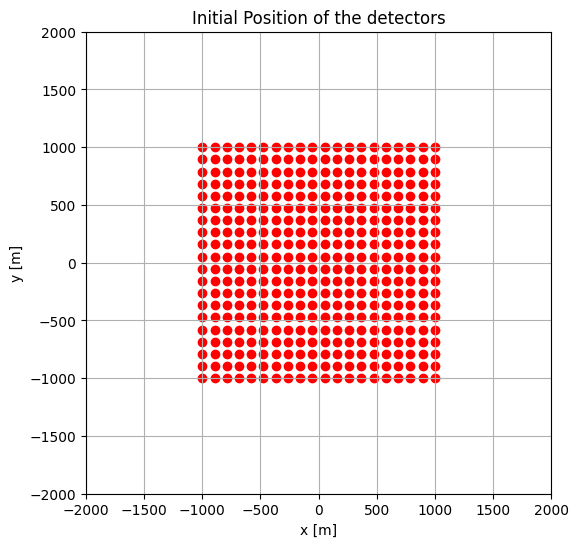

In [20]:
x, y = Layouts()

#Plot the initial positions
plt.figure(figsize = [6, 6])
plt.scatter(x, y, color = "red")
plt.grid()
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Initial Position of the detectors")
plt.xlim((-2000, 2000))
plt.ylim((-2000, 2000))

In [38]:
N, T, x0, y0, E, th, ph = GenerateShowers()

Energy = 7.078 PeV
Angle = 1.0 degree


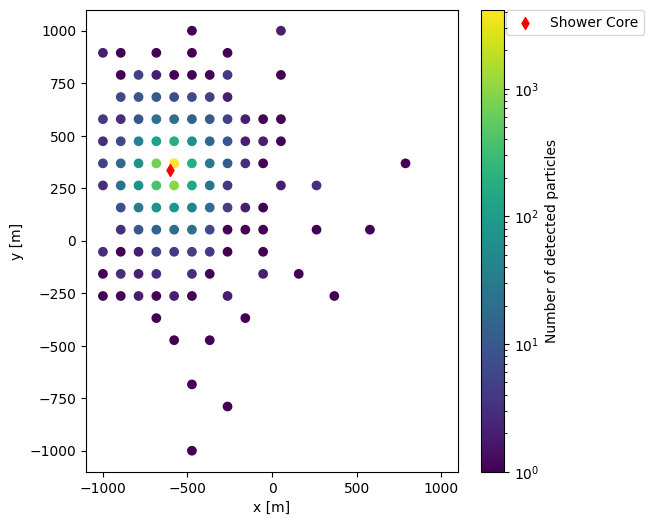

In [39]:
print(f"Energy = {E.item():.3f} PeV")
print(f"Angle = {th.item() * 180 / np.pi:.1f} degree")

norm = LogNorm(vmin = 1, vmax = np.max(N))
plt.figure(figsize = [6, 6])
scatter = plt.scatter(x, y, c = N, cmap = "viridis", norm = norm)
plt.colorbar(scatter, label='Number of detected particles')
plt.scatter(x0.item(), y0.item(), c = "red", marker = "d", label = "Shower Core")
plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1), borderaxespad=0.)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.xlim((-1100, 1100))
plt.ylim((-1100, 1100))
plt.show()

Angle = 1.0 degree
Phi = -43.0 degree


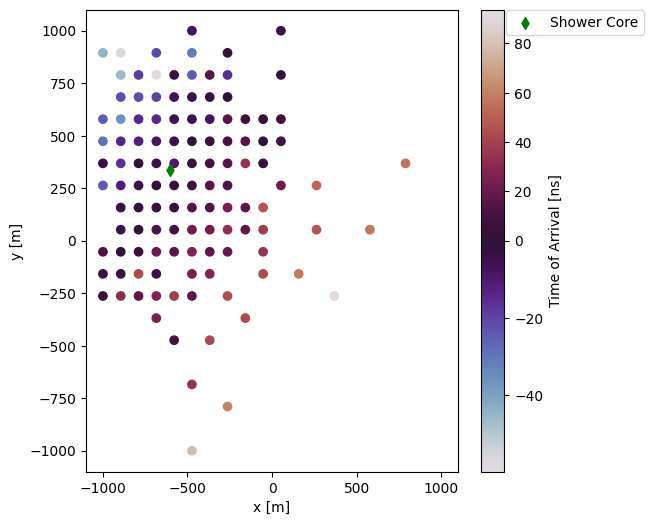

In [40]:
print(f"Angle = {th.item() * 180 / np.pi:.1f} degree")
print(f"Phi = {ph.item() * 180 / np.pi:.1f} degree")

norm = TwoSlopeNorm(vmin=np.min(T), vcenter=0, vmax=np.max(T))

idx = np.where(N > 0)
plt.figure(figsize = [6, 6])
scatter = plt.scatter(x[idx], y[idx], c = T[idx], cmap = "twilight", norm = norm)
plt.colorbar(scatter, label='Time of Arrival [ns]')
plt.scatter(x0.item(), y0.item(), c = "green", marker = "d", label = "Shower Core")
plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1), borderaxespad=0.)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.xlim((-1100, 1100))
plt.ylim((-1100, 1100))
plt.show()

## Training the Network

We first need some simulations to train our neural network. In the global variables part, you will find a variable num_events, which is set to 10000. We will use this number to generate random events.

### Test Data Generation

Number of showers in the test set = 10000

In [24]:
%%time

inputs = torch.zeros((Nevents, 400, 4))
labels = torch.zeros((Nevents, 5))

for i in range(Nevents):
    N, T, x0, y0, E, theta, phi = GenerateShowers()

    #Normalize the Labels:
    E_norm, theta_norm, phi_norm = NormalizeLabels(E, theta, phi)
    x0 = x0 / 1000 #[km]
    y0 = y0 / 1000 #[km]

    input_vector = np.column_stack((x, y, N, T))

    inputs[i] = torch.tensor(input_vector, dtype = torch.float32)
    labels[i] = torch.tensor([x0, y0, E_norm, theta_norm, phi_norm], dtype = torch.float32)

    if (i + 1) % 1000 == 0:
        print(f"Shower generation is {int((i + 1) / 100)}% done")

#We also need to normalize our inputs, otherwise it will cause a problem in NN training
inputs[:, :, 0] = inputs[:, :, 0] / 1000
inputs[:, :, 1] = inputs[:, :, 1] / 1000

torch.save(inputs, "inputs.pt")
torch.save(labels, "labels.pt")

Shower generation is 10% done
Shower generation is 20% done
Shower generation is 30% done
Shower generation is 40% done
Shower generation is 50% done
Shower generation is 60% done
Shower generation is 70% done
Shower generation is 80% done
Shower generation is 90% done
Shower generation is 100% done
CPU times: user 2h 26min 40s, sys: 15.8 s, total: 2h 26min 56s
Wall time: 2h 27min 4s


### Validation Set Data Generation

Number of events in the validation set = 1000

In [60]:
%%time

inputs_val = torch.zeros((Nvalidation, 400, 4))
labels_val = torch.zeros((Nvalidation, 5))

for i in range(Nvalidation):
    N, T, x0, y0, E, theta, phi = GenerateShowers()

    #Normalize the Labels:
    E_norm, theta_norm, phi_norm = NormalizeLabels(E, theta, phi)
    x0 = x0 / 1000 #[km]
    y0 = y0 / 1000 #[km]

    input_vector = np.column_stack((x, y, N, T))

    inputs_val[i] = torch.tensor(input_vector, dtype = torch.float32)
    labels_val[i] = torch.tensor([x0, y0, E_norm, theta_norm, phi_norm], dtype = torch.float32)

    if (i + 1) % 100 == 0:
        print(f"Shower generation is {int((i + 1) / 100)}% done")

torch.save(inputs_val, "inputs_val.pt")
torch.save(labels_val, "labels_val.pt")

Shower generation is 10% done
CPU times: user 15min 46s, sys: 2.15 s, total: 15min 48s
Wall time: 15min 51s


### Load the Sets

In [67]:
inputs = torch.load("./NN_Files/inputs.pt")
labels = torch.load("./NN_Files/labels.pt")

inputs_val = torch.load("./NN_Files/inputs_val.pt")
labels_val = torch.load("./NN_Files/labels_val.pt")

### Model

In [95]:
#In this part we are defining our model, which is the Neural network for our reconstruction
#We will use Mean Square Error Loss
#Optimization model is SGD, to keep consistent with our next steps

model = Reconstruction()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)

In [96]:
dataset = TensorDataset(inputs, labels)

dataloader = DataLoader(dataset, batch_size = 32, shuffle = True, drop_last = True)

Training is 10% done, with Loss = 0.27
Training is 20% done, with Loss = 0.18
Training is 30% done, with Loss = 0.16
Early stop at epoch 302
CPU times: user 47min 1s, sys: 1min 29s, total: 48min 30s
Wall time: 12min 20s


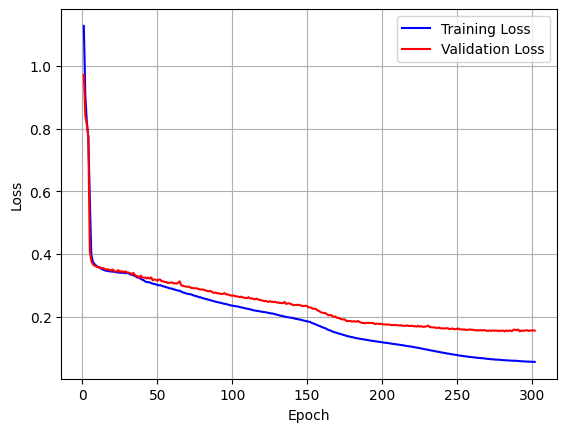

In [97]:
%%time

val_losses = []
losses = []

early_stopper = EarlyStopping()

for num_epoch in range(1000):

    epoch_loss = 0
    total_batch = 0
    
    for batch_inputs, batch_labels in dataloader:
        batch_size = batch_inputs.size(0)

        train_x = batch_inputs.view(batch_size, 1600)
        
        train_y = batch_labels.view(batch_size, 5)
        
        #Train the network
        outputs = model(train_x)

        loss = criterion(outputs, train_y)
        epoch_loss += loss.item()
        total_batch += 1

        loss.backward()
        optimizer.step()

        optimizer.zero_grad()

    #See if our loss in our validation set improves:
    val_size = inputs_val.size(0)

    val_x = inputs_val.view(val_size, 1600)
    val_y = labels_val.view(val_size, 5)

    model.eval()

    with torch.no_grad():

        val_output = model(val_x)
        val_loss = criterion(val_output, val_y)
    
    val_losses.append(val_loss.item())
    early_stopper(val_loss)

    if (num_epoch + 1) % 100 == 0:
        print(f"Training is {int((num_epoch + 1) / 10)}% done, with Loss = {val_loss:.2f}")

    losses.append(epoch_loss / total_batch)

    if early_stopper.early_stop:
        print(f"Early stop at epoch {num_epoch + 1}")
        break

plt.plot(np.arange(1, len(losses) + 1), losses, color = "blue", label = "Training Loss")
plt.plot(np.arange(1, len(val_losses) + 1), val_losses, color = "red", label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

In [98]:
E_r = []
E_p = []

X_r = []
X_p = []

Y_r = []
Y_p = []

Th_r = []
Th_p = []

Ph_r = []
Ph_p = []

for i in range(100):
    N, T, x0, y0, E, th, ph = GenerateShowers()
    X = torch.tensor(np.column_stack((x, y, N, T)), dtype = torch.float32)
    X = X.view(1, -1)

    model.eval()

    with torch.no_grad():
        output = model(X)

    x_pred = output[0, 0]
    y_pred = output[0, 1]
    E_pred = output[0, 2]
    theta_pred = output[0, 3]
    phi_pred = output[0, 4]
    E_pred, theta_pred, phi_pred = DenormalizeLabels(E_pred, theta_pred, phi_pred)
    
    E_p.append(E_pred)
    E_r.append(E.item())

    X_r.append(x0.item() * 1000)
    X_p.append(x_pred * 1000)

    Y_r.append(y0.item() * 1000)
    Y_p.append(y_pred * 1000)

    Th_r.append(th.item())
    Th_p.append(theta_pred)

    Ph_r.append(ph.item())
    Ph_p.append(phi_pred)

    if (i + 1) % 10 == 0:
        print(f"Predicted: {E_pred:.1f}, Real: {E.item():.1f}")

Predicted: 8.3, Real: 8.3
Predicted: 4.2, Real: 2.8
Predicted: 1.4, Real: 1.0
Predicted: 4.4, Real: 6.1
Predicted: 6.6, Real: 3.3
Predicted: 2.9, Real: 8.5
Predicted: 4.3, Real: 4.4
Predicted: 3.0, Real: 3.2
Predicted: 9.3, Real: 9.2
Predicted: 4.2, Real: 8.5


(array([ 5., 12.,  2.,  4.,  5.,  7.,  3.,  9.,  7.,  1.,  2.,  5.,  7.,
         1.,  5.,  3.,  7.,  7.,  4.,  4.]),
 array([0.43928969, 0.91732317, 1.39535666, 1.87339008, 2.3514235 ,
        2.82945704, 3.30749059, 3.78552389, 4.26355743, 4.74159098,
        5.21962452, 5.69765759, 6.17569113, 6.65372467, 7.13175821,
        7.60979176, 8.08782482, 8.56585884, 9.04389191, 9.52192593,
        9.99995899]),
 <BarContainer object of 20 artists>)

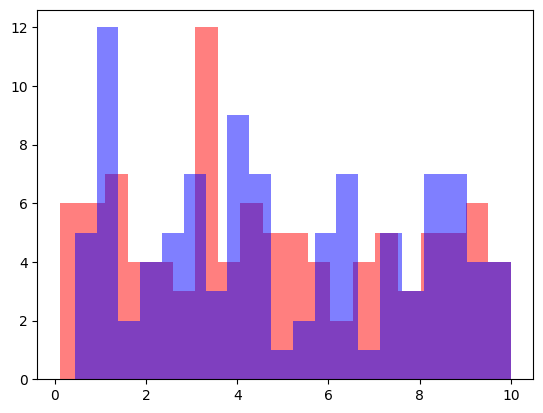

In [99]:
plt.hist(E_r, bins = 20, alpha = .5, color = "red")
plt.hist(E_p, bins = 20, alpha = .5, color = "blue")

(array([10.,  4.,  3.,  4.,  6.,  1.,  3.,  3.,  4.,  8.,  4.,  7., 14.,
         5.,  3.,  6.,  8.,  3.,  3.,  1.]),
 array([-1000.        ,  -901.53625488,  -803.07250977,  -704.60882568,
         -606.14508057,  -507.68133545,  -409.21762085,  -310.75390625,
         -212.29016113,  -113.82643127,   -15.36270142,    83.10102844,
          181.5647583 ,   280.02850342,   378.49221802,   476.95593262,
          575.41967773,   673.88342285,   772.34716797,   870.81085205,
          969.27459717]),
 <BarContainer object of 20 artists>)

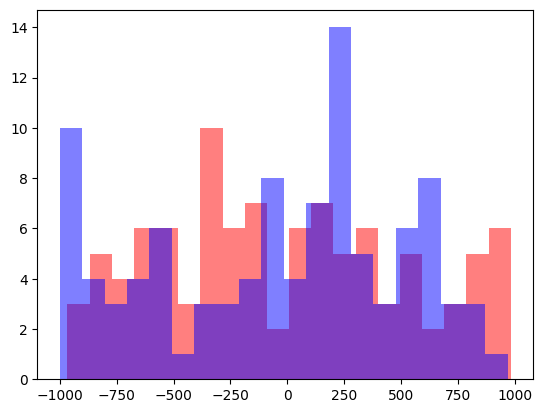

In [100]:
plt.hist(np.array(X_r) / 1000, bins = 20, alpha = .5, color = "red")
plt.hist(X_p, bins = 20, alpha = .5, color = "blue")

(array([ 7.,  3.,  2.,  3.,  3.,  3.,  6.,  2.,  4.,  6.,  6.,  1.,  3.,
         9.,  8.,  7., 16.,  2.,  5.,  4.]),
 array([-942.55651855, -852.38128662, -762.20605469, -672.03082275,
        -581.85559082, -491.68035889, -401.50509644, -311.3298645 ,
        -221.15463257, -130.97940063,  -40.8041687 ,   49.37106705,
         139.54629517,  229.72154236,  319.89675903,  410.07202148,
         500.24725342,  590.42248535,  680.59771729,  770.77294922,
         860.94818115]),
 <BarContainer object of 20 artists>)

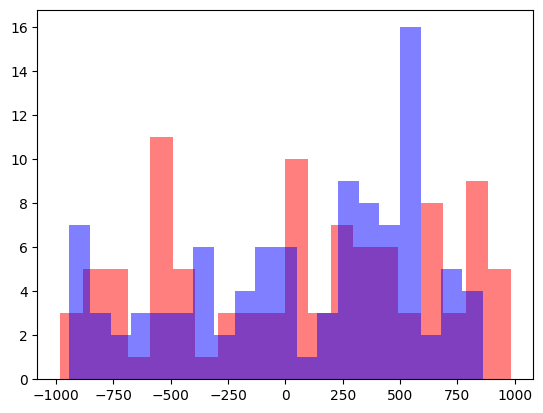

In [101]:
plt.hist(np.array(Y_r) / 1000, bins = 20, alpha = .5, color = "red")
plt.hist(Y_p, bins = 20, alpha = .5, color = "blue")

(array([ 1.,  4.,  4.,  4.,  3.,  6.,  6.,  5.,  6.,  5.,  5.,  5.,  5.,
         2.,  6.,  6.,  5.,  4.,  4., 14.]),
 array([0.        , 0.05672291, 0.11344582, 0.17016873, 0.22689164,
        0.28361455, 0.34033746, 0.39706036, 0.45378327, 0.51050615,
        0.56722909, 0.62395203, 0.68067491, 0.73739779, 0.79412073,
        0.85084367, 0.90756655, 0.96428943, 1.02101231, 1.0777353 ,
        1.13445818]),
 <BarContainer object of 20 artists>)

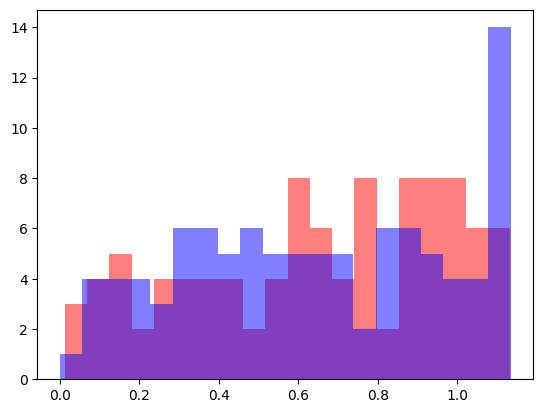

In [102]:
plt.hist(Th_r, bins = 20, alpha = .5, color = "red")
plt.hist(Th_p, bins = 20, alpha = .5, color = "blue")

(array([ 4.,  1.,  3.,  3.,  3.,  5.,  7.,  3.,  4.,  5.,  5., 12.,  4.,
         3., 12., 14.,  6.,  2.,  3.,  1.]),
 array([-3.07141614, -2.78633928, -2.50126219, -2.21618533, -1.93110824,
        -1.64603138, -1.3609544 , -1.07587743, -0.79080045, -0.50572348,
        -0.2206465 ,  0.06443046,  0.34950742,  0.63458437,  0.91966134,
         1.20473838,  1.48981524,  1.77489221,  2.05996919,  2.34504628,
         2.63012314]),
 <BarContainer object of 20 artists>)

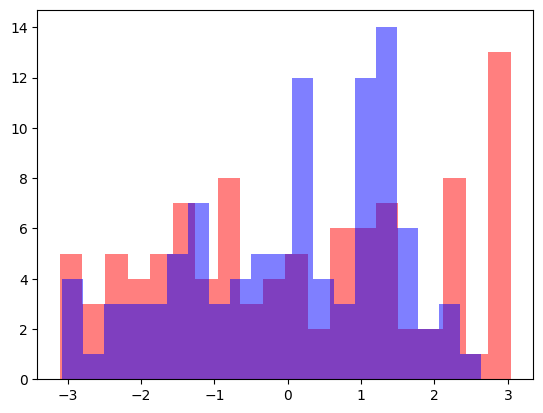

In [103]:
plt.hist(Ph_r, bins = 20, alpha = .5, color = "red")
plt.hist(Ph_p, bins = 20, alpha = .5, color = "blue")